## The dataset is from Kaggle where we have 7503 values or rows in training set and 3243 rows in test set and test set does not have target column. Dataset is about Disaster tweets and we will be classifying fake and real tweets

https://www.kaggle.com/c/nlp-getting-started/data?select=train.csv

In [1]:
import numpy as np
from nltk.tokenize import TweetTokenizer
import pandas as pd
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
ps = PorterStemmer()
import re
import seaborn as sns
import nltk
import scipy
import matplotlib.pyplot as plt
import networkx as nx
from gensim.models import word2vec
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

/Users/krishnadevabhaktuni/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('train.csv')
df.tail()
df_test = pd.read_csv('test.csv')

In [3]:
print(df_test.shape)
print(df.shape)

(3263, 4)
(7613, 5)


In [4]:
print(df.head(3))

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   

   target  
0       1  
1       1  
2       1  


In [5]:
## Checking for missing values
print(df.isnull().sum())
print(df_test.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
id             0
keyword       26
location    1105
text           0
dtype: int64


#### We can see that the target variable is not available in df_test dataset and we are going to classify the tweets in df_test dataset

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [7]:
## Removing missing values
df.drop(['keyword', 'location'], axis = 1, inplace = True)
df_test.drop(['keyword', 'location'], axis = 1, inplace = True)

In [8]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/krishnadevabhaktuni/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
## Applying Regex to remove punctuation, hyperlinks and numbers
## Converting text to lower 
## Applying Lemmatizer to stemming and get the meaninful words
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
corpus = []
for i in range(0, len(df)):
    #review = re.sub(r'^https?:\/\/.*[\r\n]*', '', df['text'][i], flags=re.MULTILINE)
    #review = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', df['text'][i], flags=re.MULTILINE)
    review = re.sub(r"http\S+", "", df['text'][i])
    review = re.sub('[^a-zA-Z\d+]', ' ', review)
    review = re.sub('[0-9]', '', review)
    review = review.lower()
    review = review.split()
    #review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = [lemmatizer.lemmatize(word, pos = 'v') for word in review if not word in stopwords.words('english')]
    review = [lemmatizer.lemmatize(word, pos = 'n') for word in review]
    review = [lemmatizer.lemmatize(word, pos = 'a') for word in review]
    review = ' '.join(review)
    corpus.append(review)

In [10]:
## We have 113,654 words in our dataset
print(df.shape)
df['text'].apply(lambda x: len(x.split(' '))).sum()

(7613, 3)


113654

In [11]:
## Applying the same for test dataset
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
corpus_test = []
for i in range(0, len(df_test)):
    review = re.sub(r"http\S+", "", df_test['text'][i])
    review = re.sub('[^a-zA-Z\d+]', ' ', review)
    review = re.sub('[0-9]', '', review)
    review = review.lower()
    review = review.split()
    review = [lemmatizer.lemmatize(word, pos = 'v') for word in review if not word in stopwords.words('english')]
    review = [lemmatizer.lemmatize(word, pos = 'n') for word in review]
    review = [lemmatizer.lemmatize(word, pos = 'a') for word in review]
    review = ' '.join(review)
    corpus_test.append(review)

In [12]:
corpus_test[1:4]

['hear earthquake different city stay safe everyone',
 'forest fire spot pond goose flee across street cannot save',
 'apocalypse light spokane wildfire']

In [13]:
corpus[1:4]

['forest fire near la ronge sask canada',
 'resident ask shelter place notify officer evacuation shelter place order expect',
 'people receive wildfire evacuation order california']

/Users/krishnadevabhaktuni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Legend does not support '0' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  import sys


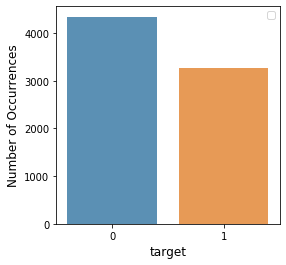

In [14]:
## Before proceeding to model, checking for class imbalance
classes = df['target'].value_counts()
plt.figure(figsize=(4,4))
sns.barplot(classes.index, classes.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('target', fontsize=12)
plt.legend('0', '1')
plt.show()

### We do not have a class imbalance in our dataset

In [15]:
## Creating a Dictionary to see most frequent words
wordfreq = {}
for sentence in corpus:
    tokens = nltk.word_tokenize(sentence)
    for token in tokens:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1

In [16]:
## Using heap module in python to see 10 most frequent words
import heapq
most_freq = heapq.nlargest(200, wordfreq, key=wordfreq.get)
most_freq[0:10]

['get', 'like', 'fire', 'amp', 'go', 'u', 'bomb', 'new', 'via', 'one']

In [17]:
## One way to create features for Bag of words
sentence_vectors = []
for sentence in corpus:
    sentence_tokens = nltk.word_tokenize(sentence)
    sent_vec = []
    for token in most_freq:
        if token in sentence_tokens:
            sent_vec.append(1)
        else:
            sent_vec.append(0)
    sentence_vectors.append(sent_vec)
sentence_vectors = np.asarray(sentence_vectors)

In [18]:
sentence_vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
## Importing CountVectorizer to create bag of words and 
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=1000)
X = cv.fit_transform(corpus).toarray()
y = df['target']

In [20]:
## These are the features for Bag of words
X[1:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [21]:
### Splitting data for training and test data and applying Naive Bayes Classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)
clf = MultinomialNB().fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

[[1141  197]
 [ 284  662]]


In [22]:
print("Training set score using Naive Bayes Classifier: {:.2f}".format(clf.score(X_train, y_train)))
print("Testing set score using Naive Bayes Classifier: {:.2f}" .format(clf.score(X_test, y_test)))

Training set score using Naive Bayes Classifier: 0.81
Testing set score using Naive Bayes Classifier: 0.79


In [23]:
lr = LogisticRegression()
print(X_train.shape, y_train.shape)
train = lr.fit(X_train, y_train)
print('Training set score using Logistic Regression:{:.2f}'.format(train.score(X_train, y_train)))
print('Test set score:{:.2f}'.format(train.score(X_test, y_test)))

(5329, 1000) (5329,)
Training set score using Logistic Regression:0.85
Test set score:0.80


In [24]:
from sklearn import ensemble
rfc = ensemble.RandomForestClassifier()
train1 = rfc.fit(X_train, y_train)

print('Training set score using Random forest Classifier:{:.2f}'.format(rfc.score(X_train, y_train)))
print('Test set score using Random Forest Classifier:{:.2f}'.format(rfc.score(X_test, y_test)))

Training set score using Random forest Classifier:0.98
Test set score using Random Forest Classifier:0.79


#### Logistic Regression is the best model from the above 3 models but the gap between test and train data is less with Naive Bayes Classifier

In [25]:
# Creating the TF-IDF model
from sklearn.feature_extraction.text import TfidfVectorizer
cv1 = TfidfVectorizer()
X_td = cv1.fit_transform(corpus).toarray()

In [26]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_td, y, test_size = 0.20, random_state = 0)

In [27]:
clf1 = MultinomialNB().fit(X_train1, y_train1)
y_pred1 = clf1.predict(X_test1)
confusion_td = confusion_matrix(y_test1, y_pred1)
print(confusion_td)
print("TF-IDF Score for Naive Bayes Training Set is {:.2f}".format(clf1.score(X_train1, y_train1)))
print("TF-IDF Score for Naive Bayes Test Set is: {:.2f}".format(clf1.score(X_test1, y_test1)))

[[791  95]
 [212 425]]
TF-IDF Score for Naive Bayes Training Set is 0.90
TF-IDF Score for Naive Bayes Test Set is: 0.80


In [28]:
lr1 = LogisticRegression()
train1 = lr1.fit(X_train1, y_train1)
print('TF-IDF score of Training set with Logistic Regression: {:.2f}'.format(lr1.score(X_train1, y_train1)))
print('TF-IDF score for Test set with Logistic Regression: {:.2f}'.format(lr1.score(X_test1, y_test1)))

TF-IDF score of Training set with Logistic Regression: 0.88
TF-IDF score for Test set with Logistic Regression: 0.81


In [29]:
text1 = df['text']

In [30]:
text = df['text']

In [31]:
nlp = spacy.load('en_core_web_sm')
text_doc = nlp('text')

In [33]:
tweet_tokenizer = TweetTokenizer()
tokens1 = []
for sent in corpus:
    for word in tweet_tokenizer.tokenize(sent):
        if len(word) < 2:
            continue
        tokens1.append(word.lower())

In [34]:
print("The number of tokens we have in our training dataset are {}" .format(len(tokens1)))

The number of tokens we have in our training dataset are 68619


In [64]:
## Creating tokens using TweetTokenizer from NLTK library
tweet_tokenizer = TweetTokenizer()
tweet_tokens = []
for sent in corpus:
    review2 = tweet_tokenizer.tokenize(sent)
    tweet_tokens.append(review2)

In [68]:
tweet_tokens[1]

['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']

In [44]:
## Removing punctuation, numbers and hyperlinks from the text
corpus1 = []
for i in range(0, len(df)):
    review1 = re.sub(r"http\S+", "", df['text'][i])
    review1 = re.sub('[^a-zA-Z\d+]', ' ', review1)
    review1 = review1.split()
    review1 = ' '.join(review1)
    corpus1.append(review1)

In [45]:
## Language Parsing using spacy
nlp = spacy.load('en_core_web_sm')
corpus_spacy = []
for i in corpus1:
    text_doc = nlp(i)
    corpus_spacy.append(text_doc)

In [50]:
from collections import Counter
# Utility function to calculate how frequently words appear in the text.
def word_frequencies(corpus_spacy, include_stop = False):
    
    # Build a list of words.
    # Strip out punctuation and, optionally, stop words.
    words = []
    for token in corpus_spacy:
        for j in token:
            if not j.is_punct and (not j.is_stop and not include_stop):
                words.append(j.text)
            
    # Build and return a Counter object containing word counts.
    return Counter(words)

In [51]:
corpus_freq = word_frequencies(corpus_spacy).most_common(20)
print('corpus_spacy includes stop words:', corpus_freq)

corpus_spacy includes stop words: [('s', 893), ('t', 495), ('amp', 344), ('like', 324), ('m', 311), ('2', 222), ('fire', 177), ('people', 167), ('3', 148), ('don', 147), ('1', 122), ('S', 118), ('California', 117), ('got', 114), ('News', 114), ('RT', 110), ('5', 109), ('new', 107), ('disaster', 106), ('New', 105)]


#### Dividing the data into target1 and target0 inorder to look at freq words in each category

In [52]:
corpus4 = ' '.join(corpus)

In [53]:
import gensim
from gensim.models import word2vec

model = word2vec.Word2Vec(
    tweet_tokens,
    workers=4,     # Number of threads to run in parallel (if your computer does parallel processing).
    min_count=50,  # Minimum word count threshold.
    window=6,      # Number of words around target word to consider.
    sg=0,          # Use CBOW because our corpus is small.
    sample=1e-3 ,  # Penalize frequent words.
    size=300,      # Word vector length.
    hs=1           # Use hierarchical softmax.
)

print('done!')

done!


In [54]:
## Find most similar words to life
print(model.wv.most_similar(positive = ['life']))

[('need', 0.9983807802200317), ('could', 0.9979541301727295), ('rescue', 0.997917115688324), ('help', 0.9977450370788574), ('man', 0.9975658655166626), ('day', 0.9972257614135742), ('call', 0.9971441030502319), ('hostage', 0.9969286322593689), ('save', 0.9967436194419861), ('keep', 0.9967174530029297)]


/Users/krishnadevabhaktuni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


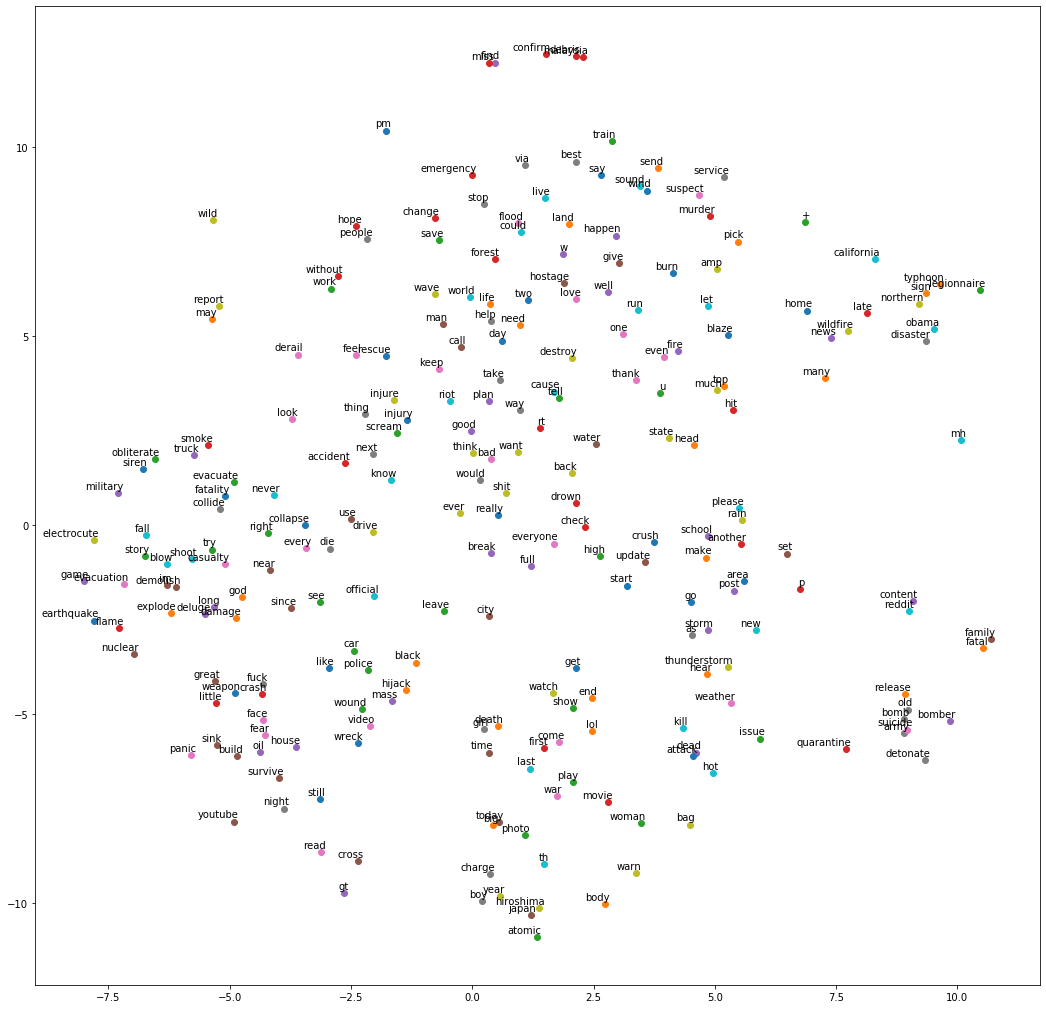

In [55]:
from sklearn.manifold import TSNE
def tsne_plot(model):
    "Create TSNE model and plot it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(18, 18)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
   
tsne_plot(model)

#### We can see from the above plot that words like collide, evacuate, crash, smoke, blow, explode, shoot are closer to each other and they should be in a real tweets.

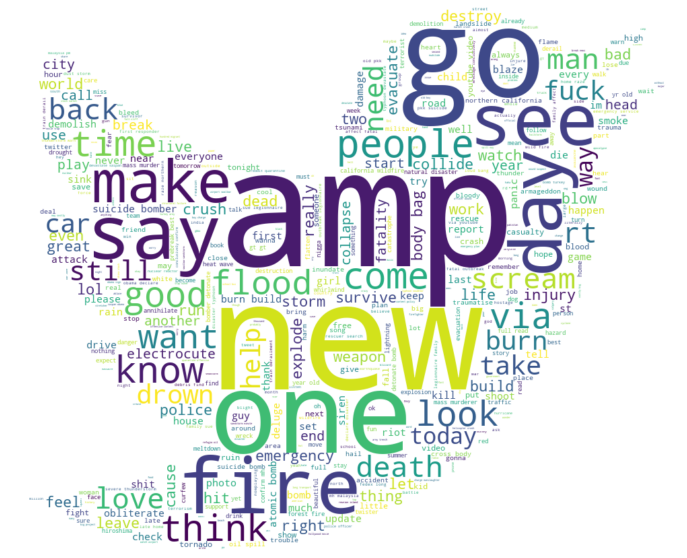

In [57]:
## Creating wordcloud for visualizing most important words
from PIL import Image
wc_text = corpus4
custom_mask = np.array(Image.open('twitter_mask.png'))

wc = WordCloud(background_color = 'white', max_words = 500, mask = custom_mask, height = 
              5000, width = 5000)
wc.generate(wc_text)
image_colors = ImageColorGenerator(custom_mask)
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [58]:
cv = CountVectorizer(max_features=1000)
test_features = cv.fit_transform(corpus_test).toarray()

In [59]:
test_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [60]:
lr = LogisticRegression()
pred = lr.fit(X,y)
print(test_features.shape)
y_pred = lr.predict(test_features)

(3263, 1000)


In [61]:
y_pred.sum()

1142

## We determined that Logistic regression using Bag of words as the best model, using our best model we have classified real and fake tweets. We have 1142 real tweets about disasters and 2121 fake tweets in the predicted test data set.